# SIR Model with Leaky Vaccination Implementation

**About these Models** <br/>
This code implements the SIR model with a leaky vaccine implementation. It first assumes homogeneous mixing within the population, and then later implements structures population contacts. A forward Euler solver is used to model the ODEs.
<br/>

**Variables Used:**
* s: the proportion of susceptibles in the population
* i: the proportion of infecteds in the population
* r: the proportion of recovereds in the population
* v: the proportion of vaccinated individuals in the population
* VE: vaccine effectiveness
* $\gamma$: 1 / the rate of recovery
* $\Delta t$: the size of each time step

## Initialization

In [1]:
#import
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#set up initial conditions
#these will be used in both models
N = 100000
VE = 0.8
fraction_vaxed = 0.5
gamma = 1/14
beta = 1/4

t_init = 0
delta_t = 0.125

i_0 = 1 / N
v_0 = fraction_vaxed
s_0 = 1 - i_0 - fraction_vaxed
r_0 = 0

## Leaky Implementation with Homogeneous Mixing
This model assumes homogeneous mixing, i.e. no population structure. This is a repeated implementation from Homework 3. 

**Variables unique to this model**<br/>
* $\beta$: the likelihood of infection transmission

In [3]:
def update(t, delta_t, current_val, f_prime):
    #the update step for a forward euler solver
    return current_val + (delta_t * f_prime(current_val))

In [4]:
#define derivatives
def s_dot_leaky(beta, i):
    return lambda s: -beta * s * i

def v_dot_leaky(beta, i, VE):
    return lambda v: (-beta * v * i) * (1 - VE)

def i_dot_leaky(beta, gamma, s, v, VE):
    return lambda i: (beta * s * i) + (beta * v * i) * (1 - VE) - (gamma * i)

def r_dot_leaky(gamma, i):
    return lambda _: gamma * i

In [5]:
def svir_leaky_solve(init_conditions, delta_t, max_time, beta, gamma, VE):
    #set up experiment loop
    t = [0]
    s =[init_conditions[0]]
    v = [init_conditions[1]]
    i = [init_conditions[2]]
    r = [init_conditions[3]]
    
    idx=0
    
    while t[idx] < max_time:
        #create derivatives
        s_update = s_dot_leaky(beta, i[idx])
        v_update = v_dot_leaky(beta, i[idx], VE)
        i_update = i_dot_leaky(beta, gamma, s[idx], v[idx], VE)
        r_update = r_dot_leaky(gamma, i[idx])
        
        #update S, I, R
        s.append(update(t[idx], delta_t, s[idx], s_update))
        v.append(update(t[idx], delta_t, v[idx], v_update))
        i.append(update(t[idx], delta_t, i[idx], i_update))
        r.append(update(t[idx], delta_t, r[idx], r_update))
    
        #upate time
        t.append(t[idx] + delta_t)
        idx += 1

    return t, s, v, i, r

In [6]:
init_conditions = [s_0, v_0, i_0, r_0]
max_t = 400
t, s, v, i, r = svir_leaky_solve(init_conditions, delta_t, max_t, beta, gamma, VE)

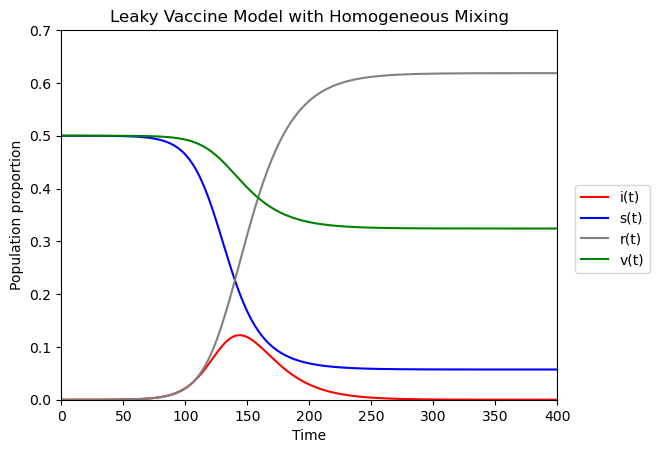

In [7]:
plt.plot(t, i, color='red', label='i(t)')
plt.plot(t, s, color='blue', label='s(t)')
plt.plot(t, r, color='gray', label='r(t)')
plt.plot(t, v, color='green', label='v(t)')

plt.legend(bbox_to_anchor=(1.2, 0.6))
plt.xlim([t[0], t[-1]])
plt.ylim([0, 0.7])

plt.xlabel('Time')
plt.ylabel('Population proportion')
plt.title('Leaky Vaccine Model with Homogeneous Mixing')

plt.show()

## Leaky Implementation with Population Structure
This model assumes that contacts within a population are structured. For now, all population groups will be assumed to have the same rate of vaccination and susceptibility. The only thing that is going to change is the contact rate between various groups. Also note that the population proportions being computed are with respect to each group's population. For example, if 50% of people in group 1 are vaccinated, then $v_1(0) = 0.5$. To convert this (or any other statistic) to the proportion with respect to the entire population, simply scale the number by the appropriate $\omega$.

**Updated Differential Equations**<br/>
The equations used above assumed homogeneous mixing, and so were not written to accommodate a matrix. Thus, we must update the equations to support matrix operations. The most notable update will be that of $\dot{v}$, since we did not derive this in class. The new equation will be: <br/>
<center>
$ \vec{\dot{v}} = -(1 - \text{VE}) \, p \, (D_v \, C \, D_\omega^{-1}) \, \vec{i}$
</center>

**List of Assumptions**<br/>
We will assume that the population consists of two groups, called $G_1$ and $G_2$. The contact matrix for the groups is as follows ($G_1$ is the first row and column):<br/>
<center>
$\begin{bmatrix}
0.8 & 0.2 \\
0.5 & 0.5 \\
\end{bmatrix}$
</center>

We will also assume the population of the groups as follows:<br/>
* $N = 100000$, as above.
* $N_1$ = 0.65(N) = 65,000
* $N_2$ = 0.35(N) = 35,000

These numbers are derived from the contact matrix above. Notice that the frequency of contacts with $G_1$ is $0.8 + 0.5 = 1.3$, and the frequency of contacts with group $G_2$ is $0.2 + 0.5 = 0.7$. We want the total number of contacts with both groups to sum up to 1. Thus, $1.3x + 0.7x = 1 \implies x = 0.5$. Taking $1.3(0.5) = 0.65$ and $0.7(0.5) = 0.35$ gives us the population proportions for each group. 

Lastly, we will assume that all population groups are equally susceptible. Since we have to separate $\beta$ into two different terms, $C$ and $p$, and since $C$ varies, we will hold $p$ constant at a value of 0.6. This number comes from nowhere in particular, and can be changed. 

In [3]:
def update(t, delta_t, current_val, f_prime):
    return current_val + (delta_t * f_prime)

In [4]:
def s_dot(p, C, D_w, D_s, i):
    return -p * (D_s @ C @ D_w) @ i

def v_dot(VE, p, C, D_w, D_v, i):
    return (-(1 - VE) * p) * (D_v @ C @ D_w) @ i

def i_dot(p, C, D_w, D_s, D_v, gamma, i, VE):
    infected_s = p * (D_s @ C @ D_w) @ i
    infected_v = ((1 - VE) * p) * (D_v @ C @ D_w) @ i
    recovered_i = gamma * i
    return infected_s + infected_v - recovered_i

def r_dot(gamma, i):
    return gamma * i

In [7]:
def solve(s_init, v_init, i_init, r_init, p, C, omegas, delta_t, max_time, gamma, VE):
    #set up omega matrix
    #NB this is really D_w^{-1} but for simplicity in variable names it's called D_w
    D_w = np.diag([1 / w for w in omegas])

    #record keeping
    s = [s_init]
    v = [v_init]
    i = [i_init]
    r = [r_init]
    t = [0]

    #solve loop
    idx = 0
    while t[idx] < max_time:
        #update D_s and D_v at each timestep
        D_s = np.diag(s[idx].flatten())
        D_v = np.diag(v[idx].flatten())
        
        #set up derivatives
        s_update = s_dot(p, C, D_w, D_s, i[idx])
        v_update = v_dot(VE, p, C, D_w, D_v, i[idx])
        i_update = i_dot(p, C, D_w, D_s, D_v, gamma, i[idx], VE)
        r_update = r_dot(gamma, i[idx])

        #update variables
        s.append(update(t[idx], delta_t, s[idx], s_update))
        v.append(update(t[idx], delta_t, v[idx], v_update))
        i.append(update(t[idx], delta_t, i[idx], i_update))
        r.append(update(t[idx], delta_t, r[idx], r_update))

        #update time
        t.append(t[idx] + delta_t)
        idx += 1

    return s, v, i, r, t

In [8]:
#set up initial conditions
num_groups = 2
p = 0.6
proportions = [0.65, 0.35]
#max time will be different since the dynamics move at different "speeds"
max_t = 125

#create arrays and vectors
C = np.array([[0.8, 0.2],[0.5, 0.5]])
omegas = np.array(proportions)

#compute proportion of susceptible, infected, etc for each group
s_init = np.array([s_0 for _ in range(num_groups)]).reshape((num_groups, 1))
v_init = np.array([v_0 for _ in range(num_groups)]).reshape((num_groups, 1))
i_init = np.array([i_0 for _ in range(num_groups)]).reshape((num_groups, 1))
r_init = np.array([r_0 for _ in range(num_groups)]).reshape((num_groups, 1))

#solve
s, v, i, r, t = solve(s_init, v_init, i_init, r_init, p, C, omegas, delta_t, max_t, gamma, VE)

#rework results so the final arrays have the two groups as the rows and their values over time as columns
all_s = np.concatenate(s, axis=1)
all_v = np.concatenate(v, axis=1)
all_i = np.concatenate(i, axis=1)
all_r = np.concatenate(r, axis=1)

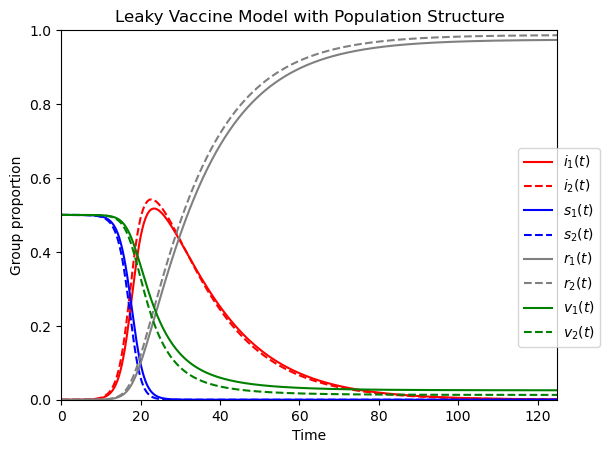

In [11]:
plt.plot(t, all_i[0, :], color='red', label=r'$i_1(t)$')
plt.plot(t, all_i[1, :], color='red', linestyle='dashed', label=r'$i_2(t)$')
plt.plot(t, all_s[0, :], color='blue', label=r'$s_1(t)$')
plt.plot(t, all_s[1, :], color='blue', linestyle='dashed', label=r'$s_2(t)$')
plt.plot(t, all_r[0, :], color='gray', label=r'$r_1(t)$')
plt.plot(t, all_r[1, :], color='gray', linestyle='dashed', label=r'$r_2(t)$')
plt.plot(t, all_v[0, :], color='green', label=r'$v_1(t)$')
plt.plot(t, all_v[1, :], color='green', linestyle='dashed', label=r'$v_2(t)$')

plt.legend(bbox_to_anchor=(1.1, 0.7))
plt.xlim([t[0], t[-1]])
plt.ylim([0, 1])

plt.xlabel('Time')
plt.ylabel('Group proportion')
plt.title('Leaky Vaccine Model with Population Structure')
plt.show()